# Preprocess zesta

## Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

warnings.filterwarnings("ignore")

## Load the dataset

In [3]:
# Load the dataset.
zf3 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zf3_stereoseq.h5ad"
)
zf3 = zf3[zf3.obs["slice"] == 1]

zf5 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zf5_stereoseq.h5ad"
)
zf5 = zf5[zf5.obs["slice"] == 10]

zf10 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zf10_stereoseq.h5ad"
)
zf10 = zf10[(zf10.obs["slice"] == 11) | (zf10.obs["slice"] == 17)]

zf12 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zf12_stereoseq.h5ad"
)
zf12 = zf12[(zf12.obs["slice"] == 8) | (zf12.obs["slice"] == 5)]

zf18 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zf18_stereoseq.h5ad"
)
zf18 = zf18[(zf18.obs["slice"] == 8) | (zf18.obs["slice"] == 11)]

zf24 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zf24_stereoseq.h5ad"
)
zf24 = zf24[zf24.obs["slice"] == 4]

adata = sc.concat((zf3, zf5, zf10, zf12, zf18, zf24))
adata.obs_names_make_unique()
del zf3, zf5, zf10, zf12, zf18, zf24

In [4]:
adata

AnnData object with n_obs × n_vars = 18175 × 13615
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors'
    layers: 'counts'

In [5]:
adata.obsm["spatial"] = adata.obs[["spatial_x", "spatial_y"]].values

In [6]:
adata.obs["Batch"] = (
    adata.obs["time_point"].astype(str) + " slice " + adata.obs["slice"].astype(str)
)

In [7]:
adata.obsm["spatial"][adata.obs["Batch"] == "18hpf slice 8"] = adata.obsm["spatial"][
    adata.obs["Batch"] == "18hpf slice 8"
] @ np.array([[0, 1], [1, 0]])
adata.obsm["spatial"][adata.obs["Batch"] == "10hpf slice 17"] = adata.obsm["spatial"][
    adata.obs["Batch"] == "10hpf slice 17"
] @ np.array([[0, 1], [1, 0]])

theta = -7 * np.pi / 4
adata.obsm["spatial"][adata.obs["Batch"] == "12hpf slice 5"] *= [1, -1]
adata.obsm["spatial"][adata.obs["Batch"] == "12hpf slice 5"] = adata.obsm["spatial"][
    adata.obs["Batch"] == "12hpf slice 5"
] @ np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

theta = -np.pi / 8
adata.obsm["spatial"][adata.obs["Batch"] == "12hpf slice 8"] = adata.obsm["spatial"][
    adata.obs["Batch"] == "12hpf slice 8"
] @ np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [8]:
adata.obsm["spatial"][adata.obs["Batch"] == "10hpf slice 11"] *= [-1, 1]
adata.obsm["spatial"][adata.obs["Batch"] == "12hpf slice 8"] *= [-1, 1]
adata.obsm["spatial"][adata.obs["Batch"] == "24hpf slice 4"] *= [-1, 1]

In [9]:
adata.obsm["spatial"][adata.obs["Batch"] == "18hpf slice 11"] *= [1, -1]

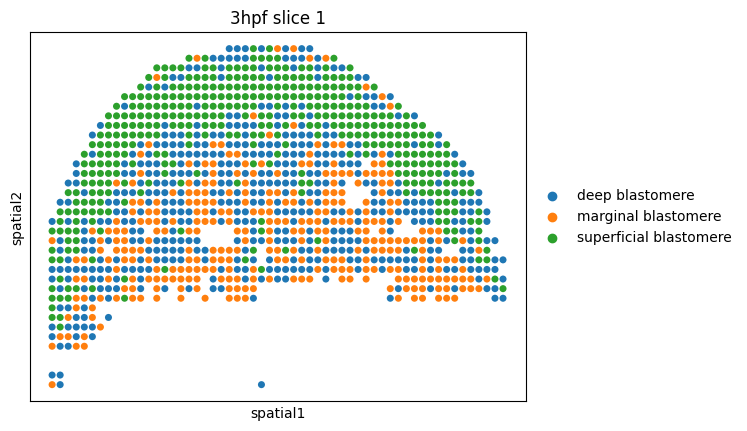

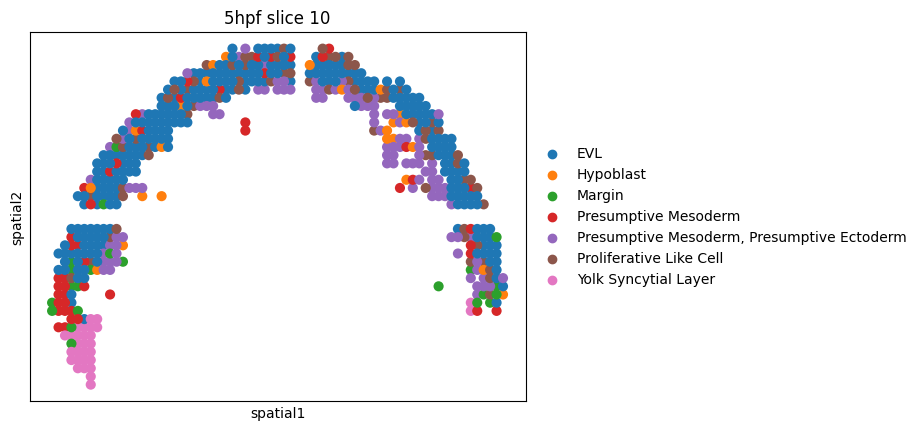

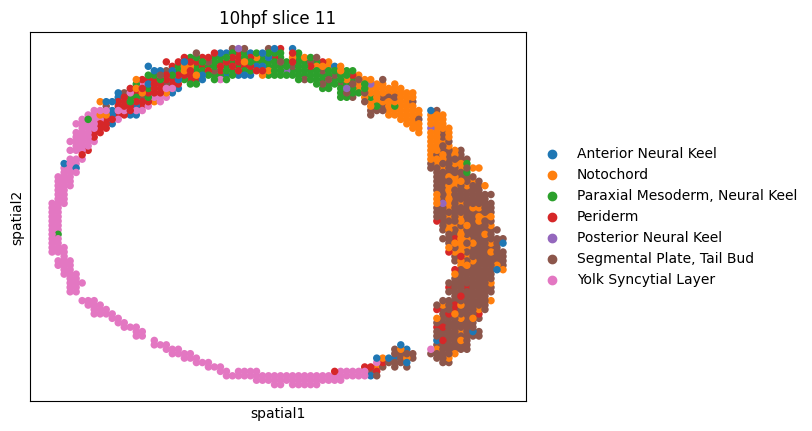

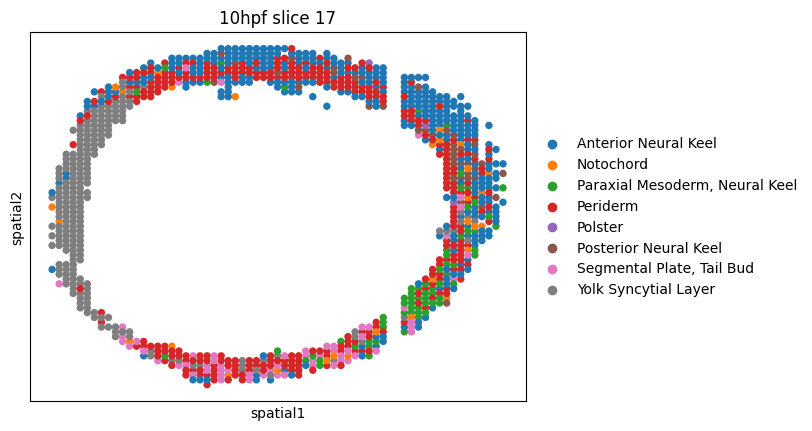

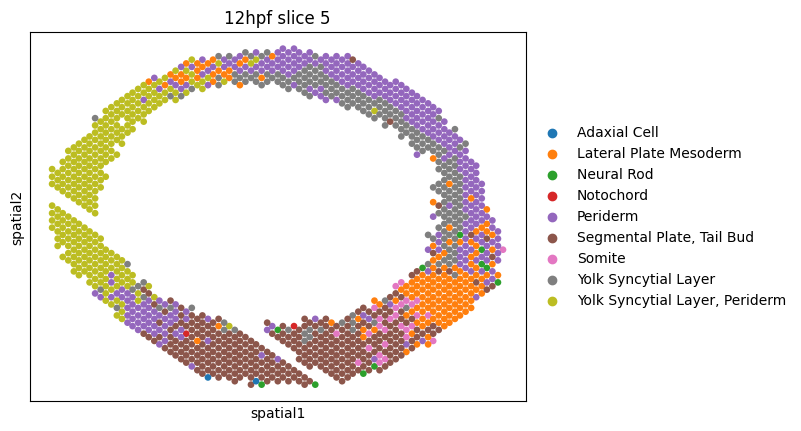

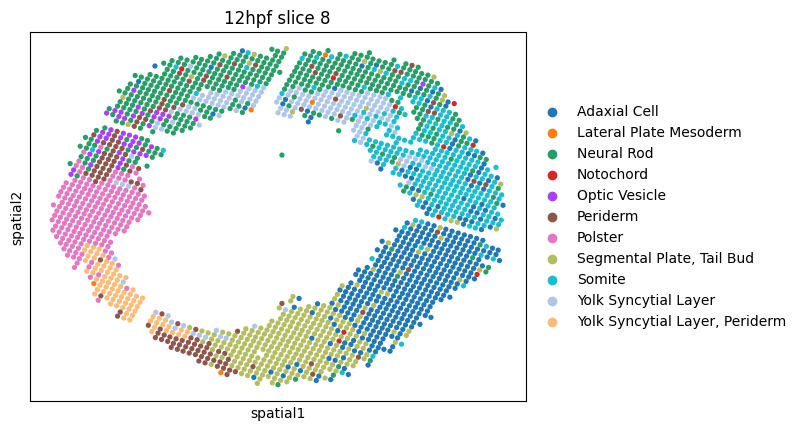

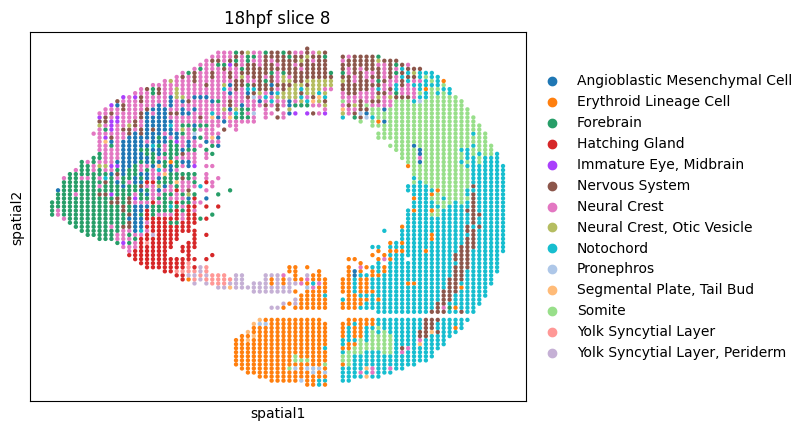

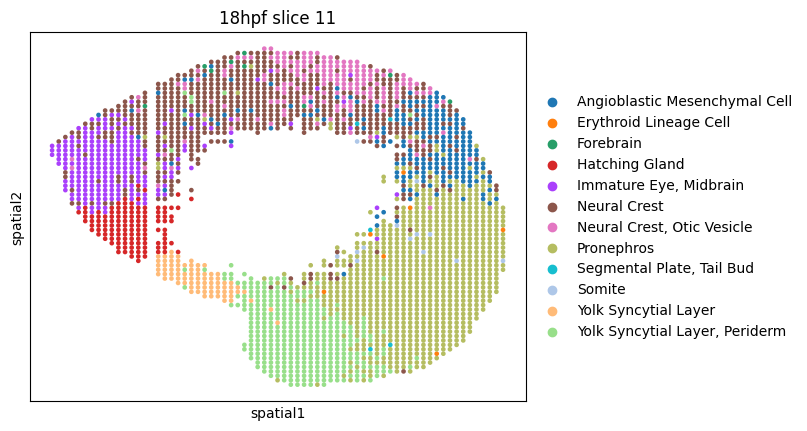

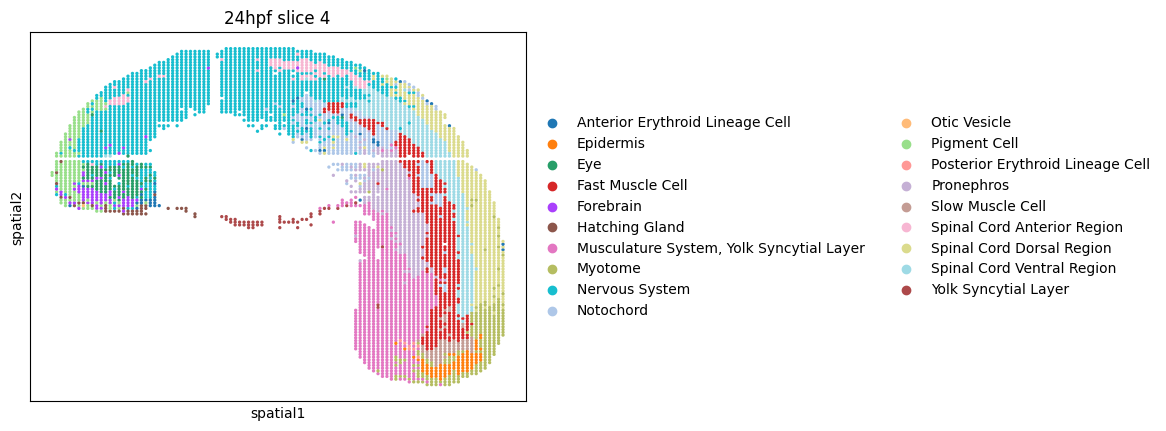

In [10]:
for b in adata.obs["Batch"].unique():
    idx = adata.obs["Batch"] == b
    sc.pl.embedding(adata[idx], "spatial", color="bin_annotation", title=b)

## Preprocess data

In [11]:
# Replace the preprocessed counts with the raw counts.
adata.X = adata.layers["counts"].copy()

In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [13]:
# Filter the counts.
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=adata.obs["n_genes_by_counts"].quantile(0.999))
sc.pp.filter_genes(adata, min_cells=3)
print("Filtered counts")

Filtered counts


In [14]:
# Compute Pearson Residuals.
sc.experimental.pp.highly_variable_genes(
    adata,
    n_top_genes=10_000,
    batch_key="Batch",
    subset=True,
    chunksize=500,
)
sc.experimental.pp.normalize_pearson_residuals(adata)
print("Computed Pearson Residuals")

Computed Pearson Residuals


In [15]:
# Apply PCA.
sc.tl.pca(adata)
print("Computed PCA")

Computed PCA


In [16]:
# Integrate the batches.
sc.external.pp.harmony_integrate(adata, key="Batch")
print("Integrated batches")

2024-05-02 19:18:18,751 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-02 19:18:22,751 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-02 19:18:22,842 - harmonypy - INFO - Iteration 1 of 10
2024-05-02 19:18:28,359 - harmonypy - INFO - Iteration 2 of 10
2024-05-02 19:18:33,889 - harmonypy - INFO - Converged after 2 iterations


Integrated batches


In [17]:
adata.obs["time"] = adata.obs["time_point"].str.replace("hpf", "").astype(float)

In [18]:
# Compute the UMAP.
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
print("Computed neighbors")
sc.tl.umap(adata)
print("Computed UMAP")

Computed neighbors
Computed UMAP


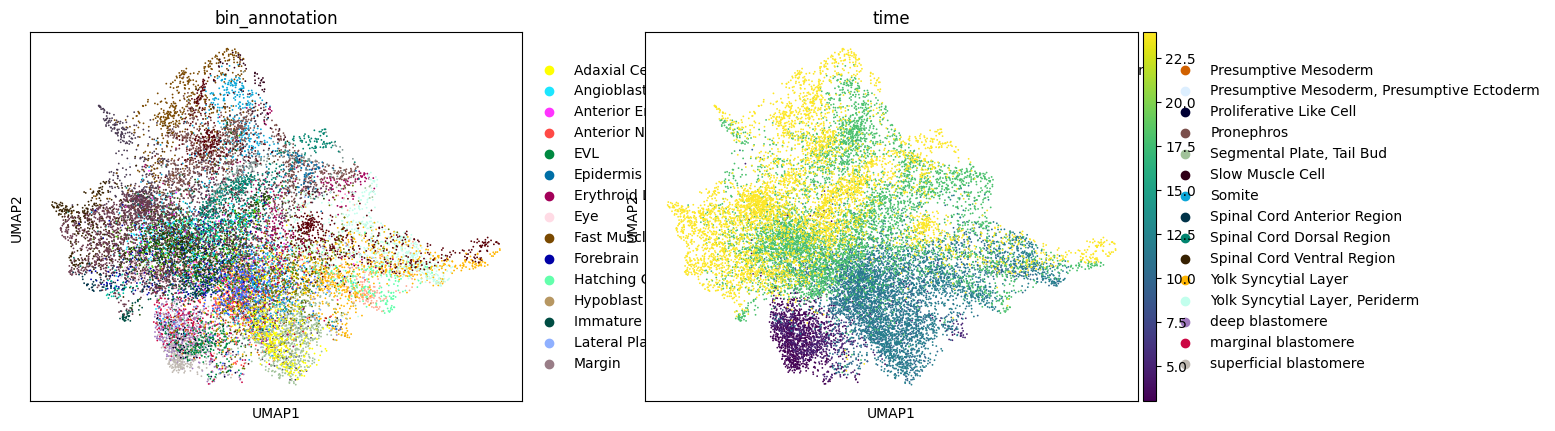

In [19]:
sc.pl.umap(adata, color=["bin_annotation", "time"], show=False)
plt.savefig(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zesta_processed.png"
)
plt.show()

In [20]:
# Save the data.
adata.write_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/zesta/zesta_processed.h5ad"
)
print("Saved data")

Saved data


In [21]:
for b in adata.obs["Batch"].unique():
    print(b)

3hpf slice 1
5hpf slice 10
10hpf slice 11
10hpf slice 17
12hpf slice 5
12hpf slice 8
18hpf slice 8
18hpf slice 11
24hpf slice 4


In [22]:
adata

AnnData object with n_obs × n_vars = 17920 × 10000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'Batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'time'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'hvg', 'pearson_residuals_normalization', 'pca', 'neighbors', 'umap', 'bin_annotation_colors'
    obsm: 'spatial', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'